# CNN

In [23]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [2]:
import os
import sys
import random
import warnings
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
import torch

from torch.utils import data
from skimage.transform import resize
from matplotlib import pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
class TGSSaltDataset(data.Dataset):
    
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        file_id = self.file_list[index]
        
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        
        return image, mask

In [4]:
train_mask = pd.read_csv('../../tgs_data/train.csv')
train_path = "../../tgs_data/train/"

file_list = list(train_mask['id'].values)
dataset = TGSSaltDataset(train_path, file_list)

In [5]:
X_train = np.zeros((len(file_list), 128, 128, 1), dtype=np.uint8)
Y_train = np.zeros((len(file_list), 128, 128, 1), dtype=np.bool)

# resize images to 128 * 128 for the u-net
for n in range(len(file_list)):
    image, mask = dataset.__getitem__(n)
    X_train[n] = resize(image[:, :, 1], (128, 128, 1), mode='constant', preserve_range=True)
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

#image, mask = dataset.__getitem__(1)

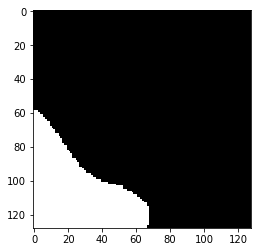

In [6]:
# Check if training data looks all right
idx=3

tmp = np.squeeze(Y_train[idx]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    
    return K.mean(K.stack(prec), axis=0)

In [8]:
# Build U-Net model
inputs = Input((128, 128, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 128, 128, 1)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 8)   80          lambda_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 128, 128, 8)   584         conv2d_1[0][0]                   
___________________________________________________________________________________________

In [10]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=0, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/50
3600/3600 [==============================] - 259s - loss: 0.0836 - mean_iou: 0.6656 - val_loss: 0.2491 - val_mean_iou: 0.6695
Epoch 2/50
3600/3600 [==============================] - 250s - loss: 0.0996 - mean_iou: 0.6734 - val_loss: 0.2174 - val_mean_iou: 0.6768
Epoch 3/50
3600/3600 [==============================] - 249s - loss: 0.0940 - mean_iou: 0.6803 - val_loss: 0.2415 - val_mean_iou: 0.6837
Epoch 4/50
3600/3600 [==============================] - 251s - loss: 0.0791 - mean_iou: 0.6874 - val_loss: 0.2859 - val_mean_iou: 0.6907
Epoch 5/50
3600/3600 [==============================] - 253s - loss: 0.0717 - mean_iou: 0.6940 - val_loss: 0.2755 - val_mean_iou: 0.6974
Epoch 6/50
3600/3600 [==============================] - 252s - loss: 0.0708 - mean_iou: 0.7006 - val_loss: 0.2731 - val_mean_iou: 0.7037
Epoch 7/50
3600/3600 [==============================] - 250s - loss: 0.0578 - mean_iou: 0.7069 - val_loss: 0.2887 - val_mean_iou: 0

# make submission

In [11]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [15]:
test_path = '../../tgs_data/test'
test_ids = next(os.walk(test_path))[2]

In [24]:
# Get and resize test images
X_test = np.zeros((len(test_ids), 128, 128, 1), dtype=np.uint8)
    
for i in range(len(test_ids)):
    path = test_path
    img = load_img(path + '/' + test_ids[i])
    x = img_to_array(img)[:, :, 1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[i] = x

In [28]:
preds_test = model.predict(X_test)

In [34]:
# Create list of upsampled test masks
preds_test_downsampled = []

for i in range(len(preds_test)):
    preds_test_downsampled.append(resize(np.squeeze(preds_test[i]), 
                                (101, 101), mode='constant', preserve_range=True))

In [ ]:
RLenc(preds_test_down)